<a href="https://colab.research.google.com/github/Rohit-Saswadkar/Sugar-Cane-disease-classification-using-CNN/blob/main/Sugar_Cane_Disease_classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Sugarcane Disease classification using CNN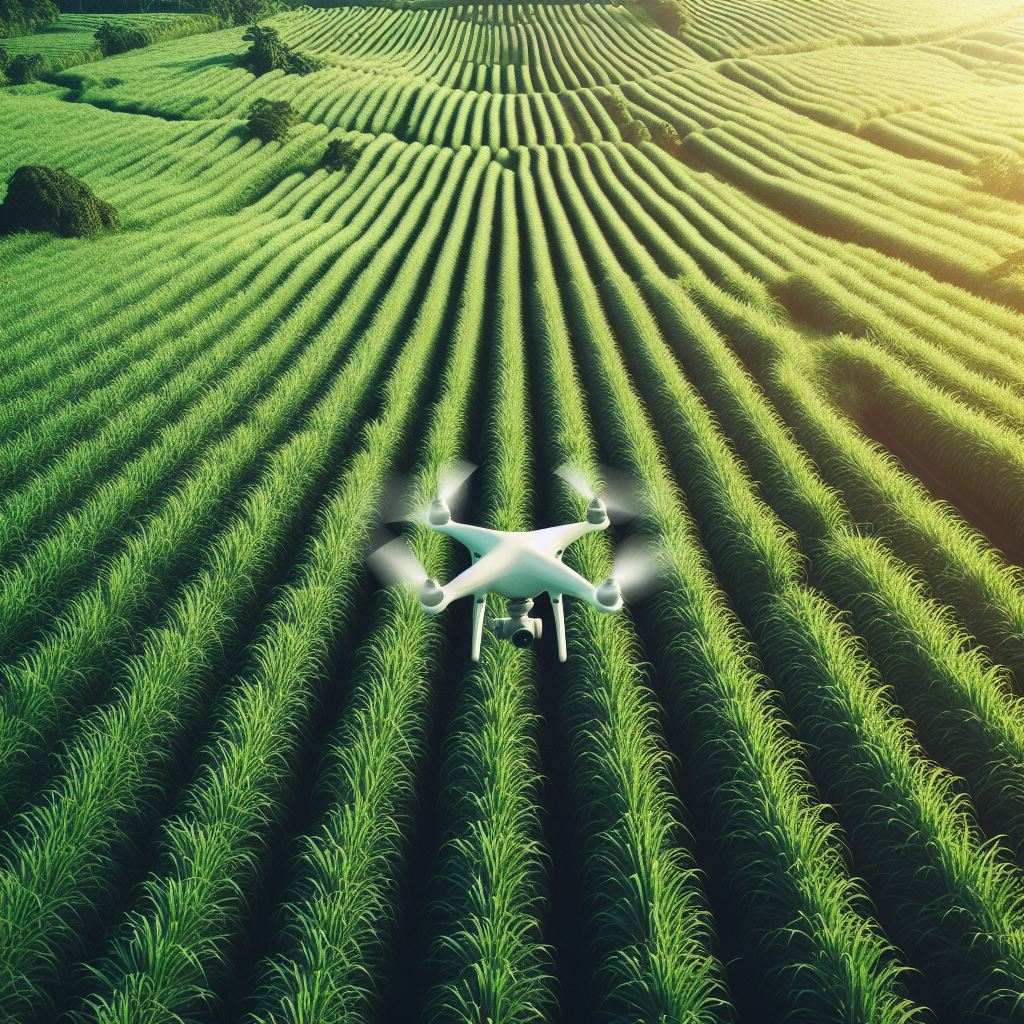**

##**Project Description:**


This project aims to develop a Convolutional Neural Network (CNN) model for the classification of sugarcane diseases. The dataset consists of images of sugarcane leaves infected with various diseases, along with healthy sugarcane leaves. The goal is to train a CNN model to accurately classify the images into their respective disease categories or label them as healthy.

**Project Goal:**
The primary goal of this project is to build an efficient CNN model that can accurately classify sugarcane leaf images into different disease categories, enabling early detection and diagnosis of sugarcane diseases. By automating the classification process, the model can assist farmers in identifying diseased plants promptly, allowing them to take timely remedial actions to mitigate crop losses. Additionally, the project aims to enhance the model's performance by incorporating data augmentation techniques such as rotation, zoom, flip, as well as optimizing the data pipeline using caching and prefetching mechanisms to expedite the training process and improve overall efficiency.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

**1] Set the image and batch size**

* The batch size determines the number of training examples processed in each iteration of gradient descent, offering efficiency and memory management benefits while influencing regularization and optimization characteristics.

* Epochs represent the number of times the entire dataset is passed forward and backward through the neural network during training, influencing model convergence and performance.

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=10

###**1] Load the dataset**

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Data Science Advanced Projects/1 Data Science Advanced/Deep learning/Sugar Cane disease classification/Sugar Cane leafes",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 768 files belonging to 3 classes.


**there are 3 classes in my dataset as Healthy means in great condition and  Redrot and Rust are diseased type plants**

In [ ]:
class_names = dataset.class_names
class_names

['Healthy', 'RedRot', 'Rust']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 0 1 0 0 0 0 0 0 2 1 0 1 0 0 2 1 2 1 1 1 2 1 1 0 2 1 2 0 0 0 2]


**Initial data view**

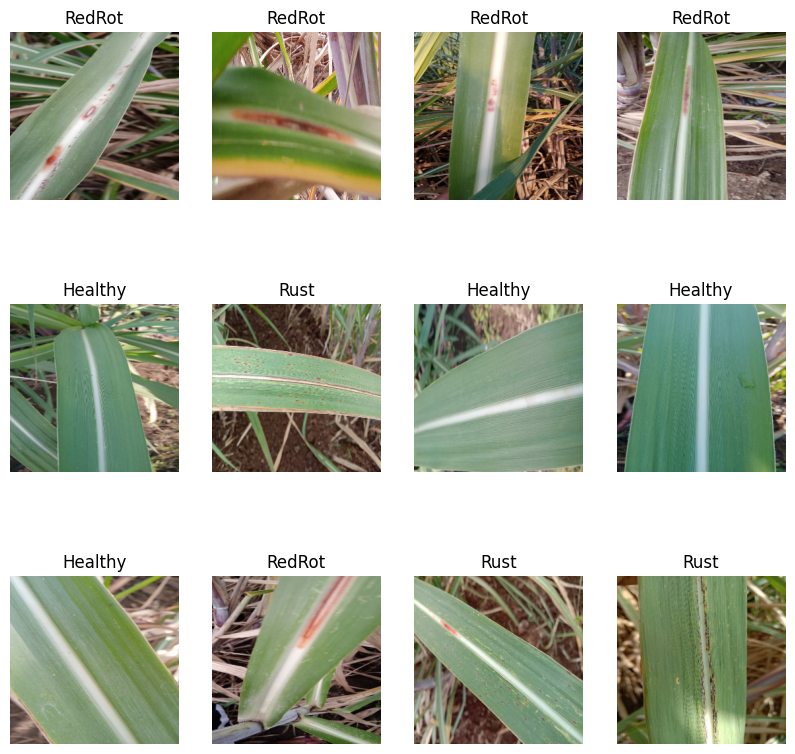

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

###**2] Function to Split Dataset**

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [ ]:
len(dataset)

24

In [ ]:
train_size = 0.8
len(dataset)*train_size

19.200000000000003

In [ ]:
train_ds = dataset.take(19)
len(train_ds)

19

In [ ]:
test_ds = dataset.skip(19)
len(test_ds)

5

In [ ]:
val_size=0.1
len(dataset)*val_size

2.4000000000000004

In [ ]:
val_ds = test_ds.take(3)
len(val_ds)

2

In [ ]:
test_ds = test_ds.skip(3)
len(test_ds)

2

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

19

In [ ]:
len(val_ds)

2

In [ ]:
len(test_ds)

3

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## **3] Building the Model**

### **Creating a Layer for Resizing and Normalization**
Before we feed our images to network, we should be resizing it to the desired size.
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### **A] Data Augmentation**
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### **B] Applying Data Augmentation to Train Dataset**

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### **C] Model Architecture**
I am using a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

I am going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

**The "Summary" function in CNN provides a concise summary of the network architecture, including the number of parameters in each layer, the output shape of each layer and the total number of trainable parameters in the model.**

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_11 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (32, 60, 60, 64)        

### **4] Compiling the Model**
I used `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
19/19 [==============================] - 118s 6s/step - loss: 1.1016 - accuracy: 0.3355 - val_loss: 1.1034 - val_accuracy: 0.3594
Epoch 2/10
19/19 [==============================] - 99s 5s/step - loss: 1.0852 - accuracy: 0.3898 - val_loss: 1.0078 - val_accuracy: 0.5781
Epoch 3/10
19/19 [==============================] - 92s 5s/step - loss: 0.9476 - accuracy: 0.5049 - val_loss: 0.9192 - val_accuracy: 0.5156
Epoch 4/10
19/19 [==============================] - 95s 5s/step - loss: 0.7473 - accuracy: 0.5855 - val_loss: 0.5075 - val_accuracy: 0.6875
Epoch 5/10
19/19 [==============================] - 90s 5s/step - loss: 0.5971 - accuracy: 0.6875 - val_loss: 0.5605 - val_accuracy: 0.6562
Epoch 6/10
19/19 [==============================] - 90s 5s/step - loss: 0.5151 - accuracy: 0.7582 - val_loss: 0.4024 - val_accuracy: 0.7656
Epoch 7/10
19/19 [==============================] - 93s 5s/step - loss: 0.4949 - accuracy: 0.7500 - val_loss: 0.4004 - val_accuracy: 0.7969
Epoch 8/10
19/19 [=

In [ ]:
scores = model.evaluate(test_ds)

3/3 [==============================] - 12s 1s/step - loss: 0.3974 - accuracy: 0.8333


In [ ]:
scores

[0.39740288257598877, 0.8333333134651184]

**Plotting the Accuracy and Loss Curves**

In [ ]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 19}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

###**5] Validation - loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

10

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.101585030555725,
 1.0851995944976807,
 0.9476031064987183,
 0.7472928762435913,
 0.5971354246139526]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

**Plotting Training and validation accuracy curves**

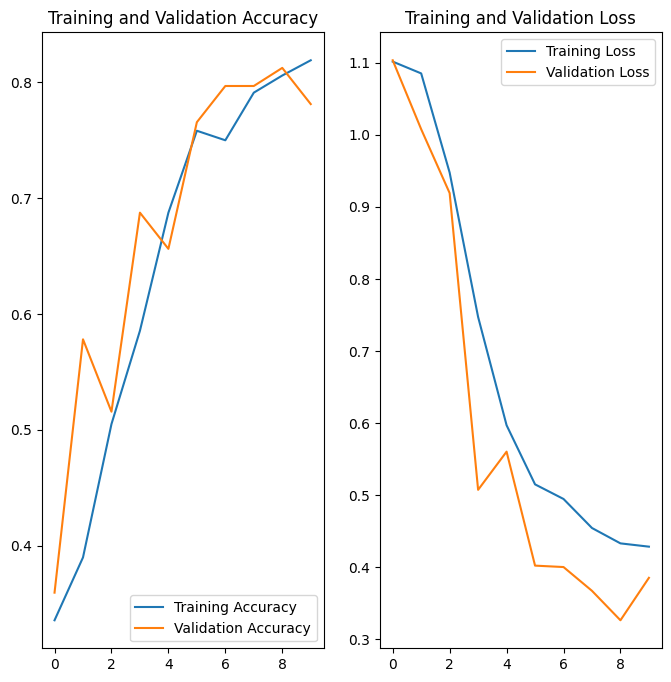

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###**6] Run prediction on a sample image**

first image to predict
actual label: Healthy
1/1 [==============================] - 2s 2s/step
predicted label: Rust


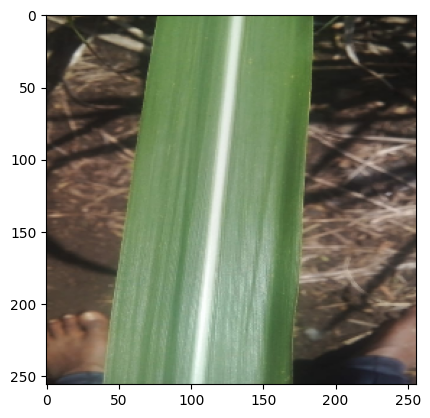

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### **7] Let's Test our model on dfferent images**

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now I am going to run inference on few sample images**

1/1 [==============================] - 0s 53ms/step


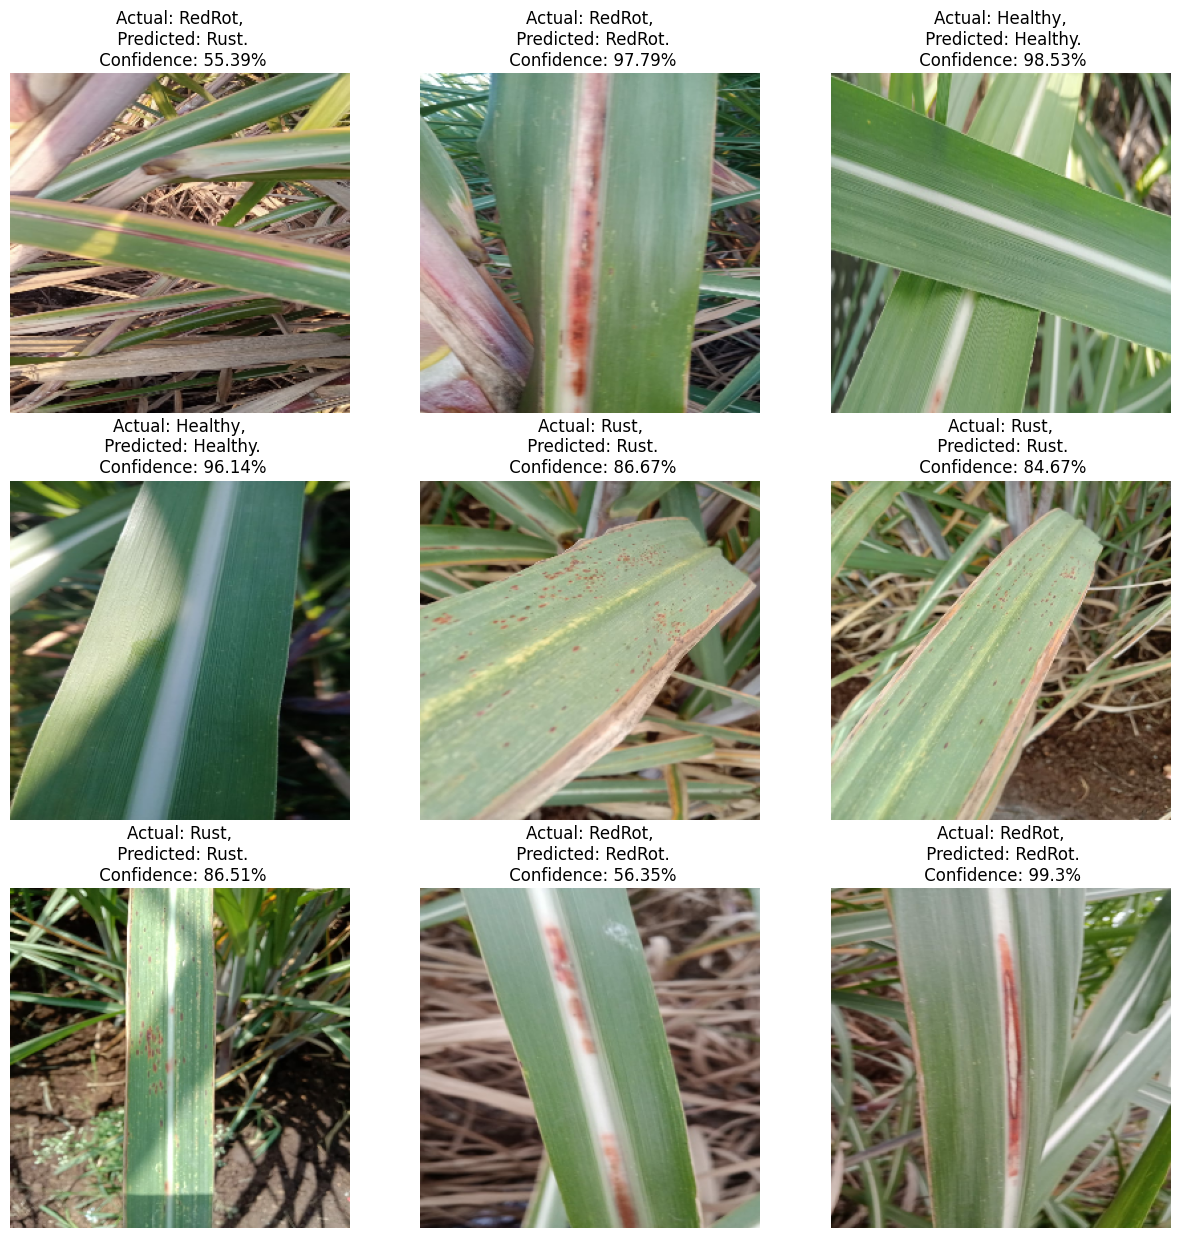

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

**Hurray! -**
1. The models demonstrated robust performance in various testing scenarios, consistently delivering accurate predictions across diverse datasets and conditions, affirming their reliability and potential for real-world deployment.

2. The observed trend of increasing accuracy with additional epochs highlights the importance of prolonged training sessions in optimizing model performance. However, hardware constraints limited training to a maximum of 10 epochs, underscoring the significance of scalable infrastructure for deep learning tasks.

3. Despite hardware limitations, the models showed promise, suggesting the potential for further optimization and refinement through extended training durations. This emphasizes the importance of computational resources in unlocking the full capabilities of deep learning models.

4. Moving forward, efforts may focus on leveraging more powerful computing resources or implementing distributed training strategies to overcome hardware constraints and maximize model performance, ultimately leading to superior predictive accuracy and enhanced scalability.